# Degrading the data

What happens when we lower the retirement limit of a galaxy? Can we still recover meaningful spiral arms?

This is the question we explore in this chapter: we take our 47 classifications and obtain samples of ten

In [40]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import groupPolylines
import spiralExtraction
import json

In [44]:
with open('classification-dump.json') as f: classifications = json.load(f)
with open('subject-dump.json') as f: subjects = json.load(f)
# print(json.dumps(list(cls[0]['links']['subjects']), indent=1))
index, _ = (next(iter(filter(
    lambda s: s[1] == '6ee8db8f-2a1e-4d10-bcb9-1e5ec84f8f10',
    ((i, list(s['locations'][0].items())[0][1].split('/')[-1].split('.')[0]) for i, s in enumerate(subjects))
))))

subjectId = subjects[index]['id']

classificationsOfSubject = list(filter(lambda c: c['links']['subjects'][0] == subjectId, classifications))
annotations = [c['annotations'] for c in classificationsOfSubject]
annotationsWithSpiral = [c[3]['value'][0]['value'] for c in annotations if len(c[3]['value'][0]['value'])]
spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
spiralsWithLengthCut = [
    [[[p['x'], p['y']] for p in a] for a in c]
    for c in spirals if all([len(a) > 5 for a in c])
]
drawnArms = np.array([np.array(arm) for classification in spiralsWithLengthCut for arm in classification])

In [73]:
np.random.seed(0)
classificationGroups = [np.random.choice(np.arange(len(annotations)), size=20, replace=False) for i in range(5)]
classificationGroups

[array([28, 33, 30,  4, 18, 11, 42, 31, 22, 10, 27, 32, 29, 43,  2, 45, 26,
        15, 25, 16]),
 array([21, 30, 33, 37,  2, 16, 29, 20,  8, 38, 22, 19, 13, 44, 26, 41, 24,
        46, 12, 27]),
 array([33, 12,  7, 15, 40, 27, 39, 20, 25,  8,  6, 16,  4,  1, 43, 44, 19,
        17, 32, 14]),
 array([17, 15,  7, 32, 10, 46, 36, 25, 33, 39,  1, 35,  5,  6,  9, 28, 18,
        27, 16, 22]),
 array([21, 14, 36, 30, 26,  4, 35, 16, 45,  9, 25, 17,  2, 19, 27, 46, 23,
        20, 28,  8])]

0
1
2
3
4


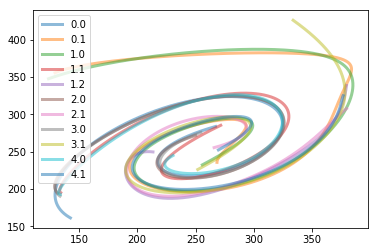

In [74]:
foo = []
for groupIndex, indices in enumerate(classificationGroups[:]):
    print(groupIndex)
    filteredAnnotations = [annotations[i] for i in indices]
    annotationsWithSpiral = [c[3]['value'][0]['value'] for c in filteredAnnotations if len(c[3]['value'][0]['value'])]
    spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
    spiralsWithLengthCut = [
        [[[p['x'], p['y']] for p in a] for a in c]
        for c in spirals if all([len(a) > 5 for a in c])
    ]
    drawnArms = np.array([np.array(arm) for classification in spiralsWithLengthCut for arm in classification])
    t = np.linspace(0, 1, 1000)
    functions = spiralExtraction.fit(drawnArms, verbose=False)
    foo.append(functions)
    for i, (Sx, Sy) in enumerate(functions):
        plt.plot((Sx(t) + 0.5) * 512, (Sy(t) + 0.5) * 512, linewidth=3, alpha=0.5, label="{}.{}".format(groupIndex, i))
        
plt.legend()

In [64]:
from sklearn.cluster import DBSCAN
indices = classificationGroups[1]
filteredAnnotations = [annotations[i] for i in indices]
annotationsWithSpiral = [c[3]['value'][0]['value'] for c in filteredAnnotations if len(c[3]['value'][0]['value'])]
spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
spiralsWithLengthCut = [
    [[[p['x'], p['y']] for p in a] for a in c]
    for c in spirals if all([len(a) > 5 for a in c])
]
drawnArms = np.array([np.array(arm) for classification in spiralsWithLengthCut for arm in classification])

In [65]:
distances = spiralExtraction.calculateDistanceMatrix(drawnArms)

In [66]:
db = DBSCAN(
    eps=20,
    min_samples=3,
    metric='precomputed',
    n_jobs=-1,
    algorithm='brute'
).fit(distances)

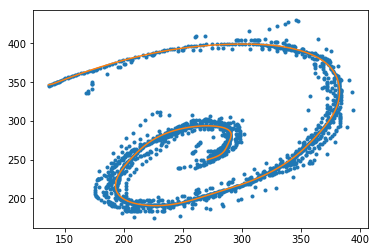

In [71]:
label = 0
pointCloud = np.array([
    point for arm in drawnArms[db.labels_ == label]
    for point in arm
])
clf, mask = spiralExtraction.cleanPoints(pointCloud)
cleanedCloud = pointCloud[mask]
armyArm = spiralExtraction.findArmyArm(drawnArms[db.labels_ == label], clf)
plt.plot(pointCloud[:, 0], pointCloud[:, 1], '.')
plt.plot(armyArm[:, 0], armyArm[:, 1])